In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
Root = "/content/drive/MyDrive/Colab Notebooks/Brain_Tumor_Detection"
os.chdir(Root)

In [3]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [4]:
data = '/content/drive/MyDrive/Colab Notebooks/Brain_Tumor_Detection/brain_tumor_dataset'
No_brain_tumor = '/content/drive/MyDrive/Colab Notebooks/Brain_Tumor_Detection/brain_tumor_dataset/no'
Yes_brain_tumor = '/content/drive/MyDrive/Colab Notebooks/Brain_Tumor_Detection/brain_tumor_dataset/yes'

In [5]:
dirlist = [No_brain_tumor, Yes_brain_tumor]
classes = ['No', 'Yes']
filepaths = []
labels = []
for i,j in zip(dirlist, classes):
  filelist = os.listdir(i)
  for f in filelist:
    filepath = os.path.join (i,f)
    filepaths.append(filepath)
    labels.append(j)
print('Filepaths', len(filepaths), 'labels', len(labels))

Filepaths 253 labels 253


In [6]:
Files = pd.Series(filepaths, name='filepaths')
Label = pd.Series(labels, name='labels')
df = pd.concat([Files, Label], axis=1)
df = pd.DataFrame(np.array(df).reshape(253, 2), columns =['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/Colab Notebooks/Brain_T...,No
1,/content/drive/MyDrive/Colab Notebooks/Brain_T...,No
2,/content/drive/MyDrive/Colab Notebooks/Brain_T...,No
3,/content/drive/MyDrive/Colab Notebooks/Brain_T...,No
4,/content/drive/MyDrive/Colab Notebooks/Brain_T...,No


In [7]:
print(df['labels'].value_counts())

labels
Yes    155
No      98
Name: count, dtype: int64


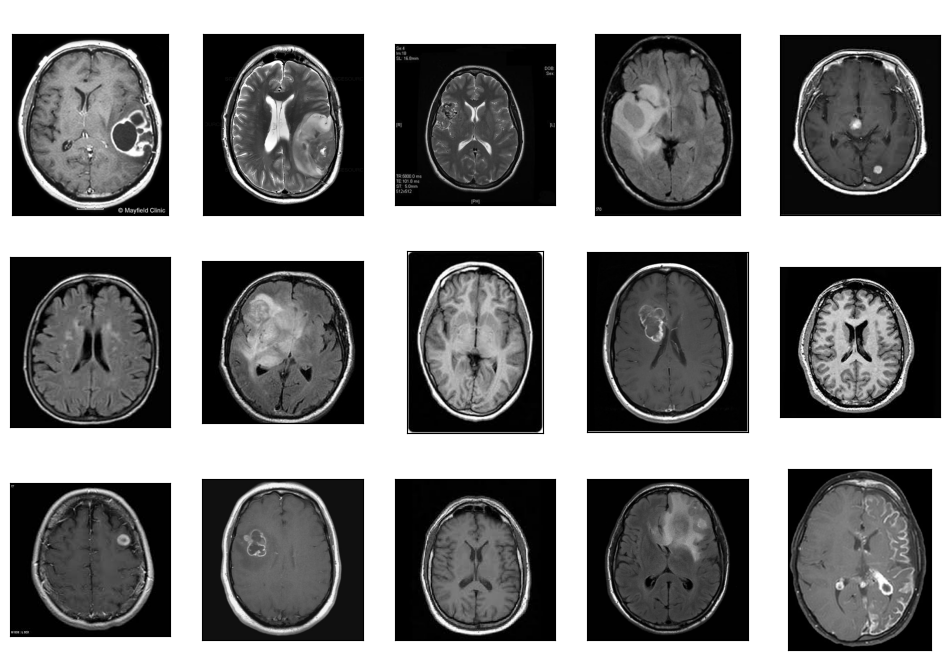

In [9]:
# visualize brain tumor images

plt.figure(figsize = (12,8))
for i in range (15):
  random = np.random.randint(1,len(df))
  plt.subplot(3,5,i+1)
  plt.imshow((cv2.imread(df.loc[random, "filepaths"])))
  plt.title(df.loc[random, "labels"], size=15, color ='white')
  plt.xticks([])
  plt.yticks([])

plt.show()

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size =0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255. , rotation_range = 40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [14]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col = 'labels',
                                              target_size = (224,224), batch_size=32,
                                              class_mode='binary', shuffle=True)

val_gen = train_datagen.flow_from_dataframe(valid,
                                            target_size=(224,224), x_col = 'filepaths', y_col = 'labels',
                                            class_mode = 'binary',
                                            batch_size=16, shuffle = True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size=(224,224), x_col='filepaths', y_col='labels',
                                            batch_size=16, shuffle=False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [15]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [17]:
#base model - InceptionResNetV2
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights = "imagenet",
    input_shape = (224,224,3),
    include_top = False,
)
base_model.trainable = False
inputs = keras.Input(shape=(224,224,3))

x= base_model(inputs, training=False)
x= keras.layers.GlobalAveragePooling2D()(x)
x= keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense( 1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [20]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.keras", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100,
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 162s 9s/step - accuracy: 0.5913 - loss: 0.9779 - val_accuracy: 0.4583 - val_loss: 1.2397
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.5368 - loss: 0.9892 - val_accuracy: 0.4583 - val_loss: 1.1458
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.5964 - loss: 0.9000 - val_accuracy: 0.5000 - val_loss: 0.9630
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.5743 - loss: 0.8218 - val_accuracy: 0.4167 - val_loss: 1.0097
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.5133 - loss: 0.9034 - val_accuracy: 0.4583 - val_loss: 0.9261
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.5010 - loss: 0.8487 - val_accuracy: 0.4167 - val_loss: 0.9118
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.5659 - loss: 0.7881 - val_accuracy: 0.5000 - val_loss: 0.9419
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.5521 - loss: 0.7670 - val_accuracy: 0.3333 - val_loss: 0.9136
Epoch 9/100

In [22]:
model.save('/content/drive/MyDrive/Colab Notebooks/Brain_Tumor_Detection/Tumor_classifier_model.keras')

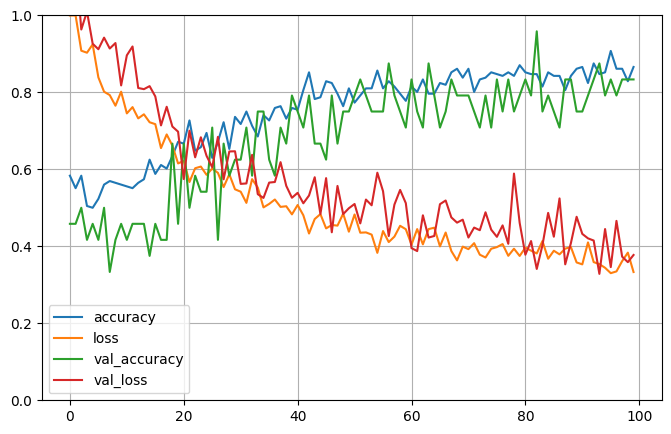

In [23]:
#Evaluate the model
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [33]:
from PIL import Image
model_path = "Tumor_classifier_model.keras"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Brain_Tumor_Detection/brain_tumor_dataset/yes/Y10.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred>=0.5:
  print("Yes")
else:
  print("No")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Yes


In [28]:
train_gen.class_indices

{'No': 0, 'Yes': 1}